In [6]:
import os

import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

import torch
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torch import nn, optim

from utils import load_all_data, squeeze_and_concat, filter_mask_keep_labels, multiclass_dice_loss
from datasets import MultiTissueDataset
from unet_basic import UNetSimple
from train_utils import EarlyStopping

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Selected device: {device}")
print(f'Num available GPUs: ', torch.cuda.device_count())


p = torch.cuda.get_device_properties()
print(f"Device: {p.name} (Memory: {p.total_memory / 1e9:.2f} GB)")

Selected device: cuda
Num available GPUs:  1
Device: NVIDIA TITAN RTX (Memory: 25.19 GB)


In [8]:
# Data import 
DATA_FOLDER = "/scratch/pdiciano/GenAI/ACDC_mine/data/ACDC_tissue_prop"

data = load_all_data(DATA_FOLDER)
data_concat = squeeze_and_concat(data)

In [9]:
print(data.keys())
print(len(data['image']), len(data['multiClassMasks']))

shapes = []

for image in data['multiClassMasks']:
    shapes.append(image.shape)
set(shapes)

assert data_concat['image'].shape[0] == data_concat['multiClassMasks'].shape[0]
assert data_concat['image'].shape[1:] == data_concat['multiClassMasks'].shape[1:]

dict_keys(['image', 'multiClassMasks', 'PD', 'T1', 'T2'])
176 176


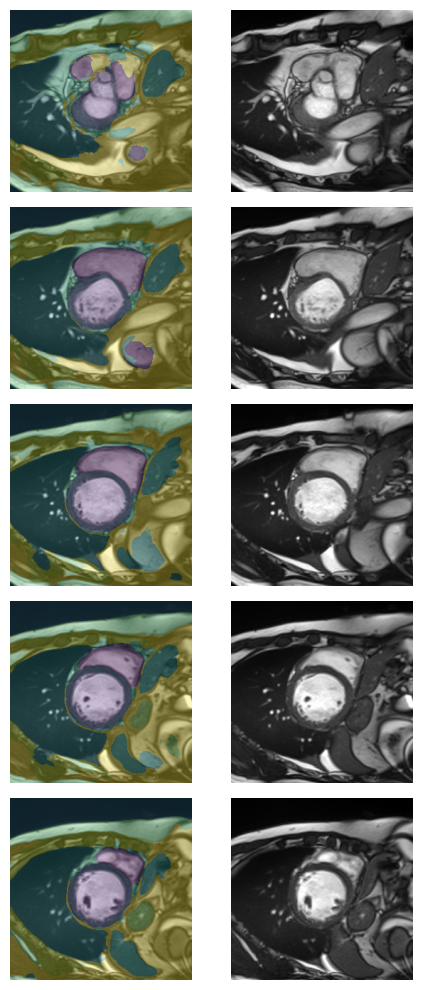

In [10]:
# print overlapping of the two arrays (image and multiClassMasks) to check if they are aligned
vol_idx = np.random.randint(0, len(data_concat['image']))


n_to_show = 5
fig, ax = plt.subplots(n_to_show, 2, figsize=(5, 10))

for i in range(n_to_show):
    img_idx = np.random.randint(0, np.array(shapes)[:,1].min()) # random index for the image slice

    ax[i, 0].imshow(data_concat['image'][i,...], cmap='gray')
    ax[i, 0].imshow(data_concat['multiClassMasks'][i,...], alpha=0.3)

    ax[i, 1].imshow(data_concat['image'][i,...], cmap='gray')

    ax[i,0].axis('off')
    ax[i,1].axis('off')

plt.tight_layout()
plt.show()

In [11]:
np.unique(data_concat['multiClassMasks'][3]), data_concat['multiClassMasks'].shape

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11], dtype=int32),
 (1648, 256, 256))

In [12]:
data_concat_tensor = torch.from_numpy(data_concat['multiClassMasks']).long()

one_hot = torch.nn.functional.one_hot(data_concat_tensor, num_classes=12)
data_concat_onehot = one_hot.permute(0, 3, 1, 2).numpy()

one_hot.shape

torch.Size([1648, 256, 256, 12])

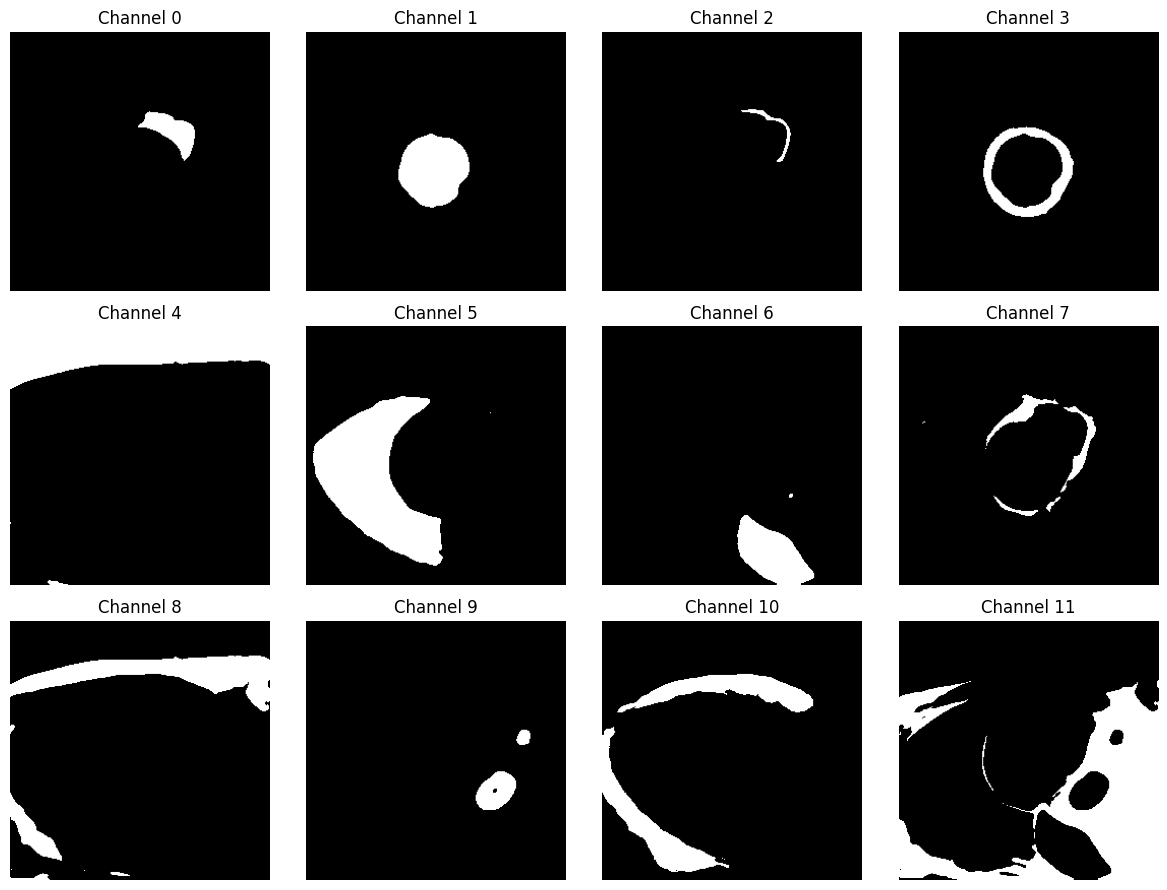

In [13]:
fig, ax = plt.subplots(3, 4, figsize=(12, 9))
ax = ax.flatten()

for i in range(12):
    ax[i].imshow(data_concat_onehot[5, i, ...], cmap='gray')
    ax[i].set_title(f'Channel {i}')
    ax[i].axis('off')

plt.tight_layout()
plt.show()

## Tissue segmentation

Left Myocardium --> label 3 \
Left ventricle --> label 1 \
Right myocardium --> label 2 \
Right ventricle --> label 0 

With "ventricle" meaning the blood pool in the segmentations. \
Based on SAX, the right myocardium is not primarily used to generate the multi-tissue labels, instead it has been generated *together with* the multi-tissue labels.

In this context however we *merge* it with the righ ventricle label (see dataset.py for the implementation)



In [14]:
mask_keep_labels = [0, 1, 2, 3]  # ventricule right, ventricule left, myocardium right, myocardium left

data_concat['input_labels'] = filter_mask_keep_labels(data_concat['multiClassMasks'], mask_keep_labels)

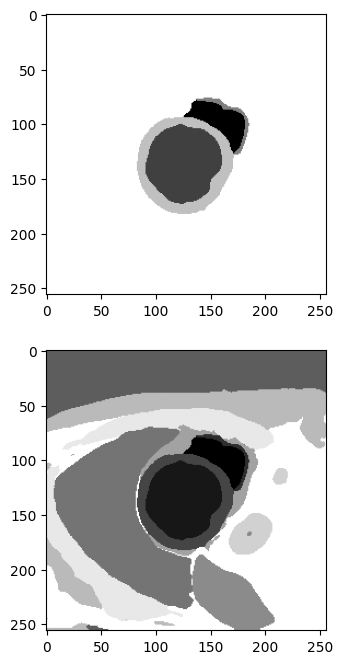

In [15]:
fig, ax = plt.subplots(2, 1, figsize=(8, 8))
ax[0].imshow(data_concat['input_labels'][5], cmap='gray')
ax[1].imshow(data_concat['multiClassMasks'][5], cmap='gray')

True

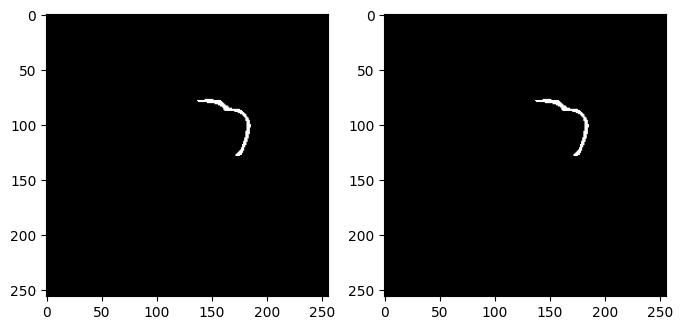

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(8, 8))
ax[0].imshow((data_concat['input_labels'][5]==2).astype(int), cmap='gray')
ax[1].imshow((data_concat['multiClassMasks'][5]==2).astype(int), cmap='gray')

np.array_equal((data_concat['input_labels'][5]==3).astype(int), (data_concat['multiClassMasks'][5]==3).astype(int))

In [17]:
np.unique(data_concat['input_labels'])

array([0, 1, 2, 3, 4], dtype=int32)

unique labels one hot:  [0. 1.]
unique labels after argmax [0 1 2 3]


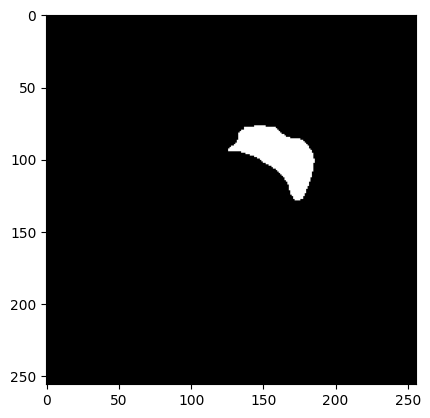

In [18]:
dataset = MultiTissueDataset(data_concat)
plt.imshow(dataset[5]['input_label'][0], cmap='gray')


print('unique labels one hot: ', np.unique(dataset[5]['input_label']))
print('unique labels after argmax', np.unique(torch.argmax(dataset[5]['input_label'], dim=0)))

Merge of right ventricle with right myocardium correctly handled: True


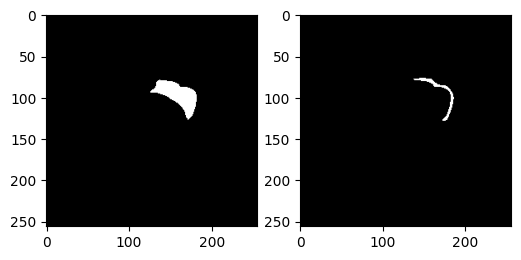

In [19]:
# checks on the merged class (right myocardium)
fig, ax = plt.subplots(1, 2, figsize=(6, 6))

ax[0].imshow((data_concat['multiClassMasks'][5] == 0).astype(int), cmap='gray')
ax[1].imshow((data_concat['multiClassMasks'][5] == 2).astype(int), cmap='gray')

manually_merged = (data_concat['multiClassMasks'][5] == 0).astype(int) + (data_concat['multiClassMasks'][5] == 2).astype(int)
print('Merge of right ventricle with right myocardium correctly handled:', 
      np.array_equal(manually_merged, dataset[5]['input_label'][0] ))

[0 1 2 3]
[ 0  1  2  3  4  5  6  7  8  9 10 11]


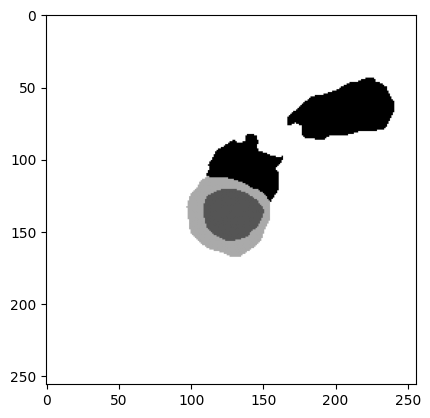

In [20]:
# instantiations and checks on the dataloader
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

batch = next(iter(dataloader))
print(np.unique(torch.argmax(batch['input_label'][7], dim=0)))

batch['input_label'].shape, batch['multiClassMask'].shape
print(np.unique(batch['multiClassMask'][7].numpy()))

plt.imshow(torch.argmax(batch['input_label'][7], dim=0), cmap='gray')

## Training basic UNet

In [24]:
lr = 1e-3
epochs = 50

patience = 10
delta = 0.01

model = UNetSimple(in_channels=4, num_classes=12, base_channels=16, depth=4, bilinear=False).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
scheduler = optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2)
early_stopping = EarlyStopping(patience=patience, delta=delta, verbose=True)

for epoch in range(epochs):
    running_loss = 0.0
    n_samples = 0

    with tqdm(dataloader, desc=f"Epoch {epoch+1}") as loop:

        for batch in loop:
            model.train()

            inputs = batch['input_label']  # (B, C, H, W)
            targets = batch['multiClassMask']  # (B, H, W)

            inputs = inputs.to(device)
            targets = targets.to(device)

            outputs = model(inputs) 
            loss = criterion(outputs, targets)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            batch_size = inputs.size(0)
            n_samples += batch_size
            running_loss += loss.item() * batch_size
            current_average_loss = running_loss / n_samples

            loop.set_postfix({'loss: ': f'{current_average_loss:.2f}',
                              'lr: ': f"{optimizer.param_groups[0]['lr']:.2e}"})
    
    scheduler.step()
    dice_score = multiclass_dice_loss(outputs, targets).item()

    # Check early stopping condition
    early_stopping.check_early_stop(loss)
    
    if early_stopping.stop_training:
        print(f"Early stopping at epoch {epoch}")
        break

    print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(dataloader):.4f}, Dice Score: {dice_score:.4f}")

Epoch 1: 100%|██████████| 103/103 [00:08<00:00, 11.92it/s, loss: =1.91, lr: =1.00e-03]


Epoch 1/50, Loss: 30.4935, Dice Score: 0.7669


Epoch 2: 100%|██████████| 103/103 [00:08<00:00, 12.16it/s, loss: =1.40, lr: =9.05e-04]


Epoch 2/50, Loss: 22.3289, Dice Score: 0.6538


Epoch 3: 100%|██████████| 103/103 [00:08<00:00, 11.81it/s, loss: =1.24, lr: =6.55e-04]


Epoch 3/50, Loss: 19.8355, Dice Score: 0.6069


Epoch 4: 100%|██████████| 103/103 [00:08<00:00, 12.00it/s, loss: =1.16, lr: =3.45e-04]


Epoch 4/50, Loss: 18.6218, Dice Score: 0.5894


Epoch 5: 100%|██████████| 103/103 [00:08<00:00, 12.00it/s, loss: =1.13, lr: =9.55e-05]


Epoch 5/50, Loss: 18.0391, Dice Score: 0.5536


Epoch 6: 100%|██████████| 103/103 [00:08<00:00, 11.85it/s, loss: =1.13, lr: =1.00e-03]


Epoch 6/50, Loss: 18.0800, Dice Score: 0.5380


Epoch 7: 100%|██████████| 103/103 [00:08<00:00, 11.47it/s, loss: =1.10, lr: =9.76e-04]


Epoch 7/50, Loss: 17.5399, Dice Score: 0.5116


Epoch 8: 100%|██████████| 103/103 [00:08<00:00, 11.57it/s, loss: =1.07, lr: =9.05e-04]


Epoch 8/50, Loss: 17.1288, Dice Score: 0.4954


Epoch 9: 100%|██████████| 103/103 [00:08<00:00, 11.57it/s, loss: =1.05, lr: =7.94e-04]


Epoch 9/50, Loss: 16.8290, Dice Score: 0.4960


Epoch 10: 100%|██████████| 103/103 [00:08<00:00, 11.92it/s, loss: =1.03, lr: =6.55e-04]


Epoch 10/50, Loss: 16.5313, Dice Score: 0.4887


Epoch 11: 100%|██████████| 103/103 [00:08<00:00, 11.98it/s, loss: =1.02, lr: =5.00e-04]


Epoch 11/50, Loss: 16.3058, Dice Score: 0.5255


Epoch 12: 100%|██████████| 103/103 [00:08<00:00, 11.86it/s, loss: =1.00, lr: =3.45e-04]


Epoch 12/50, Loss: 16.0040, Dice Score: 0.4822


Epoch 13: 100%|██████████| 103/103 [00:08<00:00, 12.11it/s, loss: =0.98, lr: =2.06e-04]


Epoch 13/50, Loss: 15.7205, Dice Score: 0.4970


Epoch 14: 100%|██████████| 103/103 [00:08<00:00, 12.23it/s, loss: =0.97, lr: =9.55e-05]


Epoch 14/50, Loss: 15.5389, Dice Score: 0.5104


Epoch 15: 100%|██████████| 103/103 [00:08<00:00, 12.10it/s, loss: =0.96, lr: =2.45e-05]


Epoch 15/50, Loss: 15.3646, Dice Score: 0.4944


Epoch 16: 100%|██████████| 103/103 [00:08<00:00, 12.04it/s, loss: =1.03, lr: =1.00e-03]


Epoch 16/50, Loss: 16.4112, Dice Score: 0.5250


Epoch 17: 100%|██████████| 103/103 [00:08<00:00, 12.11it/s, loss: =1.01, lr: =9.94e-04]


Epoch 17/50, Loss: 16.1169, Dice Score: 0.4537


Epoch 18: 100%|██████████| 103/103 [00:08<00:00, 11.91it/s, loss: =0.99, lr: =9.76e-04]


Epoch 18/50, Loss: 15.8491, Dice Score: 0.4769


Epoch 19: 100%|██████████| 103/103 [00:08<00:00, 11.80it/s, loss: =0.98, lr: =9.46e-04]


Epoch 19/50, Loss: 15.6835, Dice Score: 0.5070


Epoch 20: 100%|██████████| 103/103 [00:08<00:00, 11.77it/s, loss: =0.97, lr: =9.05e-04]


Epoch 20/50, Loss: 15.5641, Dice Score: 0.5172


Epoch 21: 100%|██████████| 103/103 [00:08<00:00, 11.75it/s, loss: =0.97, lr: =8.54e-04]


Epoch 21/50, Loss: 15.4499, Dice Score: 0.4824


Epoch 22: 100%|██████████| 103/103 [00:08<00:00, 11.83it/s, loss: =0.95, lr: =7.94e-04]


Epoch 22/50, Loss: 15.1783, Dice Score: 0.4517


Epoch 23: 100%|██████████| 103/103 [00:08<00:00, 11.83it/s, loss: =0.94, lr: =7.27e-04]


Epoch 23/50, Loss: 15.0299, Dice Score: 0.4704


Epoch 24: 100%|██████████| 103/103 [00:08<00:00, 11.89it/s, loss: =0.93, lr: =6.55e-04]


Epoch 24/50, Loss: 14.8067, Dice Score: 0.4582


Epoch 25: 100%|██████████| 103/103 [00:08<00:00, 11.93it/s, loss: =0.92, lr: =5.78e-04]


Epoch 25/50, Loss: 14.6867, Dice Score: 0.4384


Epoch 26: 100%|██████████| 103/103 [00:08<00:00, 11.94it/s, loss: =0.90, lr: =5.00e-04]


Epoch 26/50, Loss: 14.3941, Dice Score: 0.4392


Epoch 27: 100%|██████████| 103/103 [00:08<00:00, 12.03it/s, loss: =0.89, lr: =4.22e-04]

Stopping early as no improvement has been observed.
Early stopping at epoch 26


In [25]:
# Basic evaluation on the training set
with torch.no_grad():
    output = model(dataset[5]['input_label'].unsqueeze(0).to(device))
    pred_mask = torch.argmax(output, dim=1).squeeze(0).cpu().numpy()

    output_batch = model(batch['input_label'].to(device))
    pred_mask_batch = torch.argmax(output_batch, dim=1).cpu().numpy()

Text(0.5, 1.0, 'Ground Truth Mask')

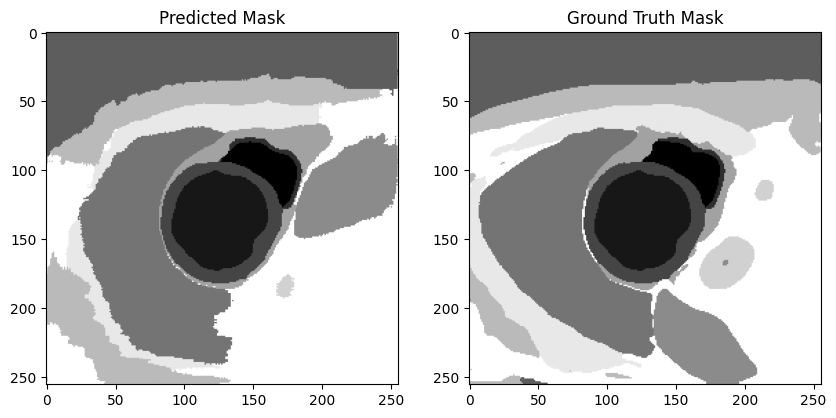

In [33]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(pred_mask, cmap='gray')
ax[0].set_title('Predicted Mask')
ax[1].imshow(data_concat['multiClassMasks'][5], cmap='gray')
ax[1].set_title('Ground Truth Mask')

In [26]:
batch['multiClassMask'].shape

torch.Size([16, 256, 256])